In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import date
from datetime import datetime
import scipy.stats

# Lectura de datos de COVID-19

In [3]:
# Lectura de datos
DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
DataFileDUS='master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv' #Muertes en Estados unidos
DataFileCUS='master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv' #Casos confirmados en estados unidos

cvaDUS = pd.read_csv('{}{}'.format(DataSource,DataFileDUS))
cvaCUS = pd.read_csv('{}{}'.format(DataSource,DataFileCUS))

In [4]:
# Obtencion de fecha del día de ayer para iniciar análisis con datos del último día
d = date.today()
AYER = str(d.month)+'/'+str(d.day-1)+'/'+str(d.year)[-2:]
AYER

'5/3/20'

In [5]:
# Datos provistos por CSSE de la universidad de Johns Hopkins
print('Casos hasta ayer en USA:',cvaCUS[AYER].sum(),'\nMuertes hasta ayer en USA:',cvaDUS[AYER].sum())

Casos hasta ayer en USA: 1158040 
Muertes hasta ayer en USA: 67682


# Limpieza de datos de COVID-19

In [6]:
# Limpieza de datos para obtenes solo casos dentro de estados federales 
COVCases = pd.DataFrame(cvaCUS.dropna().set_index(['Province_State','Admin2'])[AYER])
COVCases.columns = ['CASOS']

COVDeaths = pd.DataFrame(cvaDUS.dropna().set_index(['Province_State','Admin2'])[AYER])
COVDeaths.columns = ['MUERTES']

# Eliminar datos que categorizados como 'Unassigned'
COV = pd.merge(COVCases, COVDeaths, how = 'inner', left_index=True, right_index=True)
print('Casos sin asignar que se eliminaron:\n'+str(COV.xs('Unassigned', level='Admin2').sum()))
COV = COV.drop('Unassigned', level='Admin2')
COV.index.names = ['Estado', 'Condado']
COV

Casos sin asignar que se eliminaron:
CASOS      4905
MUERTES     531
dtype: int64


CASOS  MUERTES
Estado        Condado                  
Alabama       Autauga       48        3
              Baldwin      187        4
              Barbour       45        1
              Bibb          43        0
              Blount        40        0
...                        ...      ...
Virginia      Out of VA      0        0
Washington    Out of WA      0        0
West Virginia Out of WV      0        0
Wisconsin     Out of WI      0        0
Wyoming       Out of WY      0        0

[3193 rows x 2 columns]

# Cálculo de Mortalidad
$$ Mortalidad = \frac{Muertes}{Casos}  $$

In [26]:
COV['MORTALIDAD'] = COV['MUERTES']/COV['CASOS']
COV.head()
COV = COV.reset_index()

# Lectura de datos de PM2.5
Fuente: EPA
#### ESTE ES EL PASO  MAS LARGO

In [24]:
Directorio = 'DatosPM2.5/'
almacenarVar = False

# Lectura de primer archivo csv 
PM25 = (pd.read_csv(Directorio+'ad_viz_plotval_data.csv')
                                   .set_index(['STATE','COUNTY'])[['Date','Daily Mean PM2.5 Concentration']]
                                   .apply(lambda df : pd.Series({'Mes': int(df['Date'][0:2]),'Date':df.Date,'Promedio mensual':df['Daily Mean PM2.5 Concentration']}),axis = 1)
                                   .groupby(['STATE','COUNTY','Mes'])
                                   .mean())

for i in range(50):
    #Lectura para datos promedios mensuales para cada condado
    PMC = (pd.read_csv(Directorio+'ad_viz_plotval_data ('+str(i+1)+').csv')
                                   .set_index(['STATE','COUNTY'])[['Date','Daily Mean PM2.5 Concentration']]
                                   .apply(lambda df : pd.Series({'Mes': int(df['Date'][0:2]),'Date':df.Date,'Promedio mensual':df['Daily Mean PM2.5 Concentration']}),axis = 1)
                                   .groupby(['STATE','COUNTY','Mes'])
                                   .mean())
    
    # Paso opcional por si se quiere almacenar en variables diferentes cada información por estado
    if almacenarVar:
        estado = str(PMC.index[0][0])
        estado = estado.split()
        if len(estado)>1:
            estado = [estado[0]+'_'+estado[1]]
        estado = estado[0]
        globals()['PM_%s'%estado]=PMC
    
    PM25 = PM25.append(PMC)
    
PM25 = PM25.reset_index()

# Unión de datos de COVID y PM2.5

In [67]:
COVyPM25 = pd.merge(COV, PM25, how='inner', left_on=['Estado','Condado'], right_on=['STATE', 'COUNTY']).set_index(['Estado','Condado']).drop(['STATE','COUNTY'], axis=1).dropna()

# Obtencion de matrices de correlacion

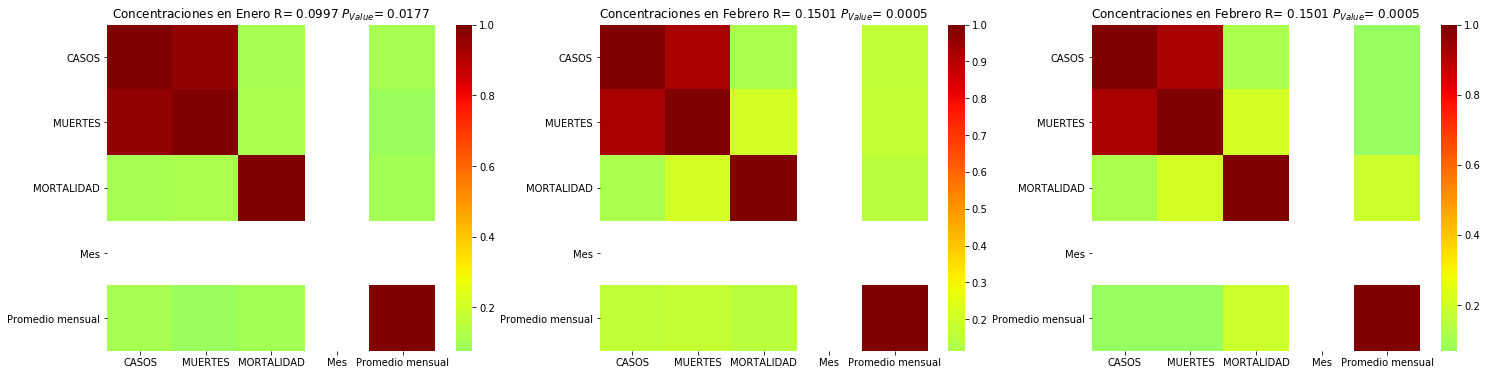

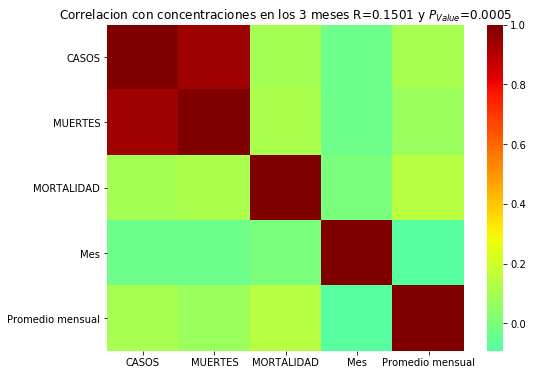

In [73]:
plt.figure(figsize=(25,6))

plt.subplot(1,3,1)
# Obtencion R Pearson y P-Value
R, PVal = scipy.stats.pearsonr(COVyPM25[COVyPM25.Mes == 1]['MORTALIDAD'],COVyPM25[COVyPM25.Mes == 1]['Promedio mensual']) 
sns.heatmap(COVyPM25[COVyPM25.Mes == 1].corr(), cmap = 'jet',center=0)
plt.title('Concentraciones en Enero R= '+str(round(R,4))+' $P_{Value}$= '+str(round(PVal,4)))

plt.subplot(1,3,2)
# Obtencion R Pearson y P-Value
R, PVal = scipy.stats.pearsonr(COVyPM25[COVyPM25.Mes == 2]['MORTALIDAD'],COVyPM25[COVyPM25.Mes == 2]['Promedio mensual']) 
sns.heatmap(COVyPM25[COVyPM25.Mes == 2].corr(), cmap = 'jet',center=0)
plt.title('Concentraciones en Febrero R= '+str(round(R,4))+' $P_{Value}$= '+str(round(PVal,4)))

plt.subplot(1,3,3)
# Obtencion R Pearson y P-Value
R, PVal = scipy.stats.pearsonr(COVyPM25[COVyPM25.Mes == 2]['MORTALIDAD'],COVyPM25[COVyPM25.Mes == 2]['Promedio mensual']) 
sns.heatmap(COVyPM25[COVyPM25.Mes == 3].corr(), cmap = 'jet',center=0)
plt.title('Concentraciones en Febrero R= '+str(round(R,4))+' $P_{Value}$= '+str(round(PVal,4)))

plt.figure(figsize=(8,6))
R, PVal = scipy.stats.pearsonr(COVyPM25[COVyPM25.Mes == 2]['MORTALIDAD'],COVyPM25[COVyPM25.Mes == 2]['Promedio mensual']) 
plt.title('Correlacion con concentraciones en los 3 meses R='+str(round(R,4))+' y $P_{Value}$=' + str(round(PVal,4)))
sns.heatmap(COVyPM25.corr(), cmap = 'jet',center=0)